In [1]:
# Library imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as optimize
import sympy as sp
from matplotlib import cm

In [2]:
# Source under probe
FreqHz = 1e6 # Fundamental frequency of simulation
Tperiod = 1 / FreqHz # Fundamental time period of simulation
Nsamp = int(1e6) # Number of samples
t = np.arange(Nsamp, dtype=float) * Tperiod # Time series: (0...Nsamp) * Time period

Tr = Tperiod * 100000 # Time period of motion we are trying to measure: 100 x sampling time period
Omega = 2 * np.pi / Tr # Omega of motion
xr = 100 * np.sin(Omega * t) # X position of motion, let's say it's a sinusoid with amplitude 100 (degrees)

/Users/charmipatel/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


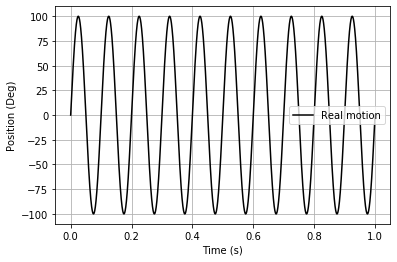

In [3]:
# Let's see what the motion looks like
plt.figure()
plt.plot(t, xr, c = 'k', label = 'Real motion')
plt.xlabel('Time (s)')
plt.ylabel('Position (Deg)')
plt.grid()
plt.legend()
plt.show()

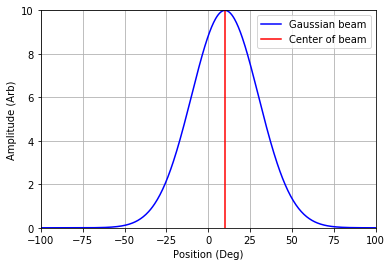

In [4]:
# This is for 1D Beam
gridMax = 100
xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing

# Define 1D Gaussian, which is our beam
def gauss1D(xx, mx, s):
    xx_ = xx - mx
    return np.exp(-0.5 * xx_ * xx_ / (s * s))

# Test Gaussian
plt.plot(xx, 10 * gauss1D(xx, 10, 20), color = 'b', label = 'Gaussian beam')
plt.xlabel('Position (Deg)')
plt.ylabel('Amplitude (Arb)')
plt.ylim(0, 10)
plt.xlim(-gridMax, gridMax)
plt.axvline(10, c = 'r', label = 'Center of beam')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Animation of the beam
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure(figsize = (10, 6))
ax = plt.axes(xlim=(-gridMax, gridMax), ylim=(0, 10))
fig.suptitle('Time: %d milliseconds' % (0))
plt.grid()
line, = ax.plot([], [], lw=2, c = 'b', label = 'Beam')
fskip = 800 # one frame per 16 milisecond

def init():
    line.set_data([], [])
    plt.legend()
    return line, # return a tuple

def animate(fid):
    tid = (fid * fskip) % xr.shape[0] # Time ID: frame ID * frame skip, the modulo keeps it from exceeding array size
    fig.suptitle('Time: %d milliseconds' % (1e3 * t[tid]))
    y = 10 * gauss1D(xx, xr[tid], 15) # beam at tid, which is index of time (time = tid * Tperiod)
    line.set_data(xx, y) # plot X and Y
#     ax.axvline(xr[tid], c = 'r', label = 'Center of beam')
    return line,

anim = animation.FuncAnimation(fig, animate, init_func = init, frames = xr.shape[0] // fskip, interval = 17, blit = True)
HTML(anim.to_html5_video()) # requires ffmpeg, install using `conda install ffmpeg`
    

In [ ]:
# This is for 2D Beam

# Now we generate our beam, which is a Gaussian in 2D space around the X coordinate
gridMax = 100
xx = np.linspace(-gridMax, gridMax, 5 * gridMax + 1, endpoint = True) # 0.04 grid spacing
yy = xx # square grid so make an alias
(xp, yp) = np.meshgrid(xx, yy) # generate X-Y plane

# Define 2D Gaussian:
def gauss2D(xx, yy, mx, my, s):
    xx_ = xx - mx # Recenter X
    yy_ = yy - my # Recenter Y
    dist = (xx_*xx_ + yy_*yy_) # calculate Euclidean distance on 2D plane
    return np.exp(-0.5 * dist / (s * s)) # Gaussian: exp(-x^2/2s^2)

# Test Gaussian
plt.figure(figsize=(6,6))
gaussval = gauss2D(xp, yp, 20, 30, 15) # beam at (20, 30), width 15
plt.imshow(gaussval, extent = [-gridMax, gridMax, -gridMax, gridMax])
plt.grid()
plt.show()

# plt.figure(figsize=(6,6))
# ax = fig.gca(projection='3d')
# ax.plot_surface(xp, yp, gaussval, cmap=cm.coolwarm)
    

# now to generate the REAL beam position with time, we need to
# generate a 3D array of the position of these 
sigr = np.array([gauss2D(xp, yp, mx, 0, 10) for mx in xr]) # beam from source, width 10

In [ ]:
sigr[:10]

## Steepest Descent
Note that, the actual beam is spread in space at every moment in time.
However, at any moment in time we can only sample one point in space (or average of a small area in space).
A-priori information is the peak of the beam at $t = 0$.
At subsequent points in time, as the peak of the beam moves about, we need to find it. 

#### At any point of time, you can ONLY sample one point in space or the average of a small area in space.

In [ ]:
def df(func , d ,h=0.01):
    xx = d[0] ; yy = d[1]
    dx = (func([(xx + h),yy]) - func([(xx - h),yy]))/(2*h)
    dy = (func([xx, (yy + h)]) - func([xx, (yy - h)]))/(2*h)
    return [dx,dy]


In [ ]:
guesses = [[-42,30]]
precision = 1/1000000
max_interations = 100
alpha = 0.1
count = 0

x0 = guesses[0][0]  # guess x
y0 = guesses[0][1] # guess y
while True:
    print(guesses)
    x_temp = x0 - alpha * df( f , [x0,y0] )[0]
    y_temp = y0 - alpha * df( f , [x0,y0] )[1]
    
    guesses.append([x_temp,y_temp])
    
    count += 1
#     print(count)
    if count > max_interations:
        print ("too many iternations, adjust alpha")
        break
    
    if abs(x_temp - guesses[0][0]) < precision and abs(y_temp - guesses[0][1]) < precision:
        break
    
    
    x0 = x_temp
    y0 = y_temp

fig = plt.figure(figsize= (10,8))
plt.contour(x_mesh, y_mesh, f_mesh, 50)
it_array = np.array(guesses)
plt.plot(it_array.T[0], it_array.T[1], "x-")
ax.set_xlabel('x')
ax.set_ylabel('y')

print("the minima is at :", guesses[-1])